In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

In [3]:
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle

In [4]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(CellAgent):
    

    def __init__(self, model, cell):
        
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):

    def __init__(self, n=10, width=10, height=10, seed=None):
        
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Create agents
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

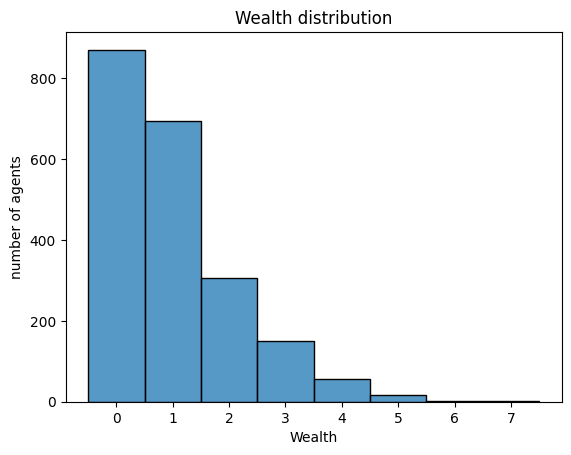

In [5]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()

g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [6]:
def agent_portrayal(agent):
    return AgentPortrayalStyle(color="tab:orange", size=50)

In [7]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

In [8]:
plot_comp = make_plot_component("encoding", page=1)